In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r LELSD.zip LELSD

Scanning files ... .
  adding: LELSD/ (stored 0%)
  adding: LELSD/Dockerfile (deflated 22%)
  adding: LELSD/LICENSE (deflated 41%)
  adding: LELSD/environment.yml (deflated 46%)
  adding: LELSD/models/ (stored 0%)
  adding: LELSD/models/__init__.py (deflated 70%)
  adding: LELSD/models/face_bisenet/ (stored 0%)
  adding: LELSD/models/face_bisenet/model.py (deflated 83%)
  adding: LELSD/models/face_bisenet/resnet.py (deflated 68%)
  adding: LELSD/models/face_bisenet/__pycache__/ (stored 0%)
  adding: LELSD/models/face_bisenet/__pycache__/resnet.cpython-39.pyc (deflated 46%)
  adding: LELSD/models/face_bisenet/__pycache__/model.cpython-39.pyc (deflated 63%)
  adding: LELSD/models/face_bisenet/__pycache__/model.cpython-37.pyc (deflated 66%)
  adding: LELSD/models/face_bisenet/__pycache__/resnet.cpython-37.pyc (deflated 46%)
  adding: LELSD/models/stylegan1/ (stored 0%)
  adding: LELSD/models/stylegan1/stylegan1.py (deflated 76%)
  adding: LELSD/models/stylegan1/dnnlib/ (stored 0%)
  addin

In [ ]:
!git remote add origin https://github.com/miki998/styleSpaceGan3-pytorch

In [4]:
%cd drive/My\Drive/LELSD/

/content/drive/MyDrive/LELSD


In [ ]:
!pip install boto3 botocore awscli --ignore-installed
!pip install ninja
!pip install torch==1.9.1

     |████████████████████████████████| 132 kB 4.2 MB/s 
     |████████████████████████████████| 8.7 MB 18.0 MB/s 
     |████████████████████████████████| 3.8 MB 39.2 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 138 kB 56.8 MB/s 
     |████████████████████████████████| 247 kB 56.4 MB/s 
     |████████████████████████████████| 636 kB 43.3 MB/s 
     |████████████████████████████████| 547 kB 46.6 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascienc

     |████████████████████████████████| 108 kB 4.2 MB/s 
     |████████████████████████████████| 831.4 MB 6.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os
# import streamlit as st
import torch

import sys

sys.path.append("../")
import models
from lelsd import LELSD
from utils.biggan_utils import BigGANSampleGenerator
from utils.stylegan1_utils import StyleGAN1SampleGenerator
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.stylegan3_utils import StyleGAN3SampleGenerator

import cv2

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1. Sample generator for stylegan2 testing

In [ ]:
model2available_dataset = {
    "stylegan2": {
        "FFHQ": "ffhq.pkl",
        "MetFaces": "metfaces.pkl",
        "LSUN Car": "stylegan2-car-config-f.pkl",
        "LSUN Horse": "stylegan2-horse-config-f.pkl",
        "LSUN Church": "stylegan2-church-config-f.pkl",
    }
    
}

In [ ]:
def load_pretrained_model(model_name, dataset_name):
    if model_name != "biggan":
        G = models.get_model(model_name,
                             f"../pretrained/{model_name}/{model2available_dataset[model_name][dataset_name]}")
    else:
        G = models.get_model(model_name, model2available_dataset[model_name][dataset_name])
    return G

def get_batch_data(sample_generator, seed, model_name, dataset_name, bs=10):
    batch_data = sample_generator.generate_batch(seed, return_image=True, return_style=True, batch_size=bs)
    return batch_data

In [ ]:
# globals 
model_name     = 'stylegan2'
dataset_name   = 'FFHQ'
truncation_psi = 0.7

In [ ]:
G      = load_pretrained_model(model_name, dataset_name)
device = torch.device('cuda')
sample_generator = StyleGAN2SampleGenerator(G=G, device=device, truncation_psi=truncation_psi)

1. Generate Style Channels and Image 

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


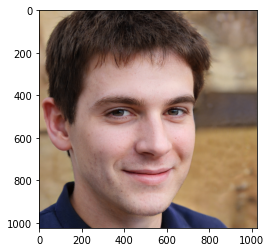

In [ ]:
original_batch_data = get_batch_data(sample_generator, 900, model_name, dataset_name, bs=1)
original_image      = original_batch_data['image'][0]
plt.imshow(original_image)

2. Finding Gradient Map of generated image (one layer: default=4) 

In [ ]:
from torch.autograd.functional import jacobian
from torchvision.transforms import Resize
import torch.nn.functional as F

# we make a function so to compute the jacobian of such a function
def func_generator(YS, RGBYS, layer=4, fs=32):
    """
    desc: generate a function to compute the jacobian of
    args: 
        - YS   ::[list] (list of layers containing style channels)
        - RGBYS::[list] (list of layers for toRGB)
        - layer::[int]  (layer #th to give as input to generated func)
        - fs   ::[int]  (filter size applied to gradient map to avg resize)
    ret : 
        - f    ::[func] (function to generate resized image)
        - inp  ::[array](supposed input for function generated)

    """
    def f(x):
        inputs   = YS[:layer] + [x] + YS[layer+1:]
        toResize = sample_generator.generate_image_from_ys(inputs, RGBYS, raw=True)[0]

        # pooling 
        pooling  = torch.nn.AvgPool2d((fs,fs), stride=(fs,fs))
        
        return pooling(toResize)

    inp = YS[layer]

    return f, inp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


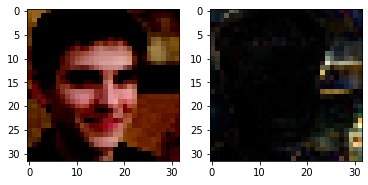

In [ ]:
# instantiating inputs of ys Latent Space
ys     = original_batch_data['ys']
rgb_ys = original_batch_data['rgb_ys']

L            = 4 # modify here which layer you wish to compute the channels jacobian of
l4func, inp  = func_generator(ys, rgb_ys, layer=L) 

generatedImg = l4func(inp).cpu().permute(1,2,0) 
grads        = jacobian(l4func, inp) # here we computed all jacobians for the specific generated image that you see below (ys,rgb_ys are specific to that image)

gradMapCh1   = grads[:,:,:,0,0].permute(1,2,0).cpu()
gradMapCh1   = torch.abs(gradMapCh1)/gradMapCh1.max()

fig ,ax = plt.subplots(1,2)
ax[0].imshow(generatedImg)
ax[1].imshow(gradMapCh1)

3. Finding segmented semantics on generated image and resizing to gradient map size

In [ ]:
from utils.segmentation_utils import FaceSegmentation

In [ ]:
face_bisenet      = models.get_model("face_bisenet", "../pretrained/face_bisenet/model.pth")
face_segmentation = FaceSegmentation(face_bisenet=face_bisenet, device=device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
import torchvision.transforms as T

In [ ]:
segmented     = face_segmentation.predict(original_image).cpu()
resized_image = T.Resize(size=32)(segmented[0])[0]
face_mask     = (resized_image==1)

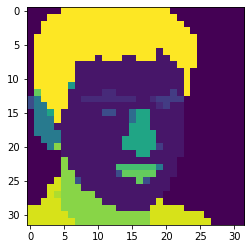

In [ ]:
plt.imshow(resized_image)

4. Computing score for a specific channel and specific semantic mask

In [ ]:
# refs: (1st: compute IOU script | 2nd: rank the different values over the generated images/style channels )
# - https://github.com/betterze/StyleSpace/blob/main/align_mask.py
# - https://github.com/betterze/StyleSpace/blob/main/semantic_channel.py 

def OverlapScore(mask2,tmp_mask):
    o=tmp_mask.sum() #size of semantic mask
    if o==0:
        return np.nan,np.nan,np.nan
    
    p=o/(mask2.shape[0]*mask2.shape[1])
    
    threshold=np.percentile(mask2.reshape(-1),(1-p)*100)
    gmask=mask2>threshold

    n=np.logical_and(gmask,tmp_mask).sum().item()
    u=np.logical_or(gmask,tmp_mask).sum().item()
    o = o.item()

    return n,u,o
    
def GetScore(mask2,semantic_mask2):
#    scores=np.zeros(len(semantic_mask2))
    scores=[]
    for i in range(len(semantic_mask2)):
        tmp_mask=semantic_mask2[i]
        n,u,o=OverlapScore(mask2,tmp_mask)
        scores.append([n,u,o])
    scores=np.array(scores)
    return scores

# own code 
def iouScore(score, d=2):
    n,u,o = score
    
    return (n/o**2)

def getGradCh(gradients, channel):
    """ 
    desc: select a specific gradient map for one channel, process it and rid of other color channels
    args: 
        - gradients::[array] (original gradients computed directly from the jacobian func)
        - channel  ::[int] (select channel careful of index we don't go check it here)
    ret :
        - gradMap  ::[array] (gradient map for channel picked)
    """
    gradMap   = gradients[:,:,:,0,channel].permute(1,2,0).cpu()
    gradMap   = torch.abs(gradMap)/gradMap.max()

    return gradMap[:,:,0]

Here we show a contrast bewteen an active channel VS an unactive channel for the specific semantics we seek for (i.e face in general). 
Note that we use a <b> single color channel mask</b> since we checked on small samples of image that the gradient map doesn't seem to change across color channels.

In [ ]:
# let's first compute the scores over the channels
scores = np.zeros((grads.shape[-1]))
for c in range(grads.shape[-1]):
    gradMap   = getGradCh(grads, c)

    # we re-use the same face_mask as it is the region we are interested in for our current image
    score     = OverlapScore(gradMap, face_mask)

    scores[c] = iouScore(score)

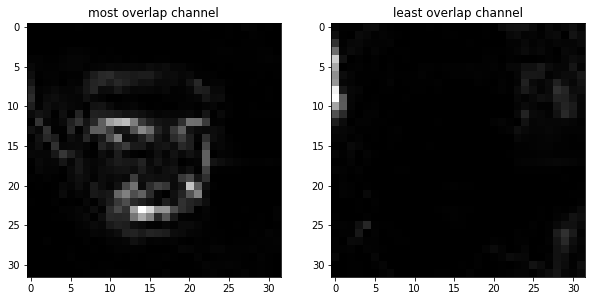




Top active channel in face roi within layer 4 for 1 generated image
##############################
Most active style channel : 110
Least active style channel: 481


In [ ]:
cmax = np.argmax(scores)
cmin = np.argmin(scores)

gradMapCmax = getGradCh(grads, cmax)
gradMapCmin = getGradCh(grads, cmin)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(gradMapCmax, cmap='gray')
ax[0].set_title('most overlap channel')
ax[1].imshow(gradMapCmin, cmap='gray')
ax[1].set_title('least overlap channel')
plt.show()

print('\n\n\nTop active channel in face roi within layer 4 for 1 generated image')
print('##############################')
print("Most active style channel : {}".format(cmax))
print("Least active style channel: {}".format(cmin))